In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from boltzmann_machines.RTRBM_no_bias import RTRBM_nobias
from boltzmann_machines.RTRBM import RTRBM

In [2]:
N_V = 10
T = 25
n_batches = 300
N_H = 3

data = torch.zeros(N_V, T, n_batches)

pre_defined_sparse_rtrbm = RTRBM(data, N_H=N_H, device='cpu')

Text(403.4117647058824, 0.5, 'amount')

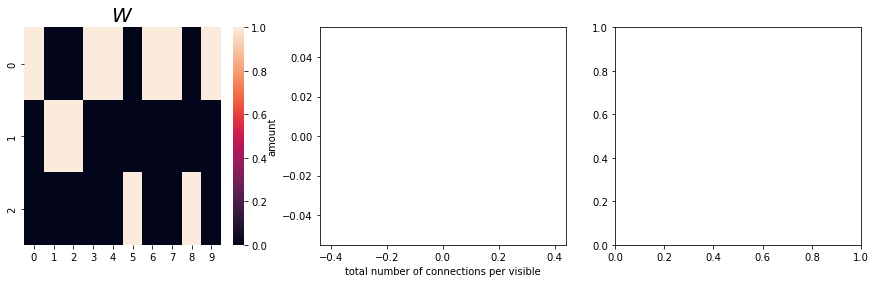

In [52]:
W = torch.zeros(N_H, N_V)
for V in range(N_V):
    n_conn = 1

    hidden_conn = torch.randint(low=0, high=N_H, size=(int(n_conn), 1))
    while torch.sum(hidden_conn == hidden_conn.T) > n_conn:
        hidden_conn = torch.randint(low=0, high=N_H, size=(int(n_conn), 1))

    x = torch.rand(1)
    if x > .5:
        W[hidden_conn, V] = 1
    else:
        W[hidden_conn, V] = 1


max_number_of_conn = int(torch.max(torch.sum(torch.abs(W), 0)))
tmp = torch.zeros(max_number_of_conn)
for i in range(max_number_of_conn):
    tmp[i] = torch.sum(torch.sum(torch.abs(W), 0) == i)

fig, axes = plt.subplots(1, 3, figsize=(15,4))
sns.heatmap(W, ax=axes[0])
axes[0].set_title('$W$', fontsize=20)
axes[1].bar(torch.arange(max_number_of_conn), tmp)
axes[1].set_xlabel('total number of connections per visible')
axes[1].set_ylabel('amount')


Find a balanced network

tensor([0.9467, 0.7055, 0.4603])
tensor([0.9934, 0.9495, 0.9347])
tensor([0.9930, 0.1325, 0.0745])
tensor([0.9938, 0.9906, 0.9070])
tensor([0.9860, 0.8937, 0.6681])
tensor([0.9905, 0.8080, 0.9094])
tensor([0.9987, 0.8618, 0.3295])
tensor([0.9677, 0.6657, 0.1875])
tensor([0.9680, 0.4063, 0.8457])
tensor([0.9974, 0.9358, 0.6801])
tensor([0.3680, 0.2226, 0.3479])


Text(0.5, 1.0, '$r^{[t]}$')

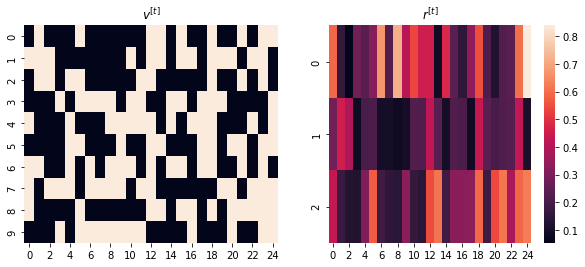

In [54]:
from tqdm import tqdm
b_init = torch.zeros(1, N_H, dtype=torch.float)
b_V = torch.zeros(1, N_V, dtype=torch.float)
b_H = torch.zeros(1, N_H, dtype=torch.float)

pre_defined_sparse_rtrbm.W = W
pre_defined_sparse_rtrbm.W_acc = torch.randn(N_H, N_H)
pre_defined_sparse_rtrbm.b_V = -.5 * torch.ones(1, N_V)
pre_defined_sparse_rtrbm.b_H = torch.randn(1, N_H) + torch.randn(1)
pre_defined_sparse_rtrbm.b_init = torch.randn(1, N_H) + torch.randn(1)
v_start = (torch.rand(N_V) > 0.2)*1.0
data, rt = pre_defined_sparse_rtrbm.sample(v_start.type(torch.float), chain=T, pre_gibbs_k=100, gibbs_k=100, mode=1, disable_tqdm=True)
print(torch.mean(rt, 1))
while torch.min(torch.mean(rt, 1) < .2) or torch.max(torch.mean(rt, 1) > .8):
    pre_defined_sparse_rtrbm.W_acc = torch.randn(N_H, N_H)
    pre_defined_sparse_rtrbm.b_H = torch.randn(1, N_H) + torch.randn(1)
    pre_defined_sparse_rtrbm.b_init = torch.randn(1, N_H) + torch.randn(1)
    v_start = (torch.rand(N_V) > 0.2)*1.0
    data, rt = pre_defined_sparse_rtrbm.sample(v_start.type(torch.float), chain=T, pre_gibbs_k=100, gibbs_k=100, mode=1, disable_tqdm=True)
    print(torch.mean(rt, 1))

fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.heatmap(data, ax=axes[0], cbar=False)
axes[0].set_title('$v^{[t]}$')
sns.heatmap(rt, ax=axes[1])
axes[1].set_title('$r^{[t]}$')

Can the RTRBM train on this? (with bias -aid)

In [55]:
data = torch.zeros(N_V, T, n_batches)
rt = torch.zeros(N_H, T, n_batches)
for batch in tqdm(range(n_batches)):
    v_start = (torch.rand(N_V) > 0.2)*1.0
    data[:, :, batch], rt[:, :, batch] = pre_defined_sparse_rtrbm.sample(v_start.type(torch.float), chain=T, pre_gibbs_k=0, gibbs_k=20, mode=1, disable_tqdm=True)

100%|██████████| 300/300 [00:16<00:00, 18.38it/s]


In [69]:
rtrbm = RTRBM(data, N_H=N_H, device='cpu')
rtrbm.b_V = -.5 * torch.ones(1, N_V)
#rtrbm.W = torch.zeros(N_H, N_V)
#rtrbm.b_H = pre_defined_sparse_rtrbm.b_H
#rtrbm.b_init = pre_defined_sparse_rtrbm.b_init
rtrbm.learn(n_epochs=1000, lr=1e-5, batchsize=100, CDk=25, mom=0, wc=0)

100%|██████████| 1000/1000 [47:18<00:00,  2.84s/it]


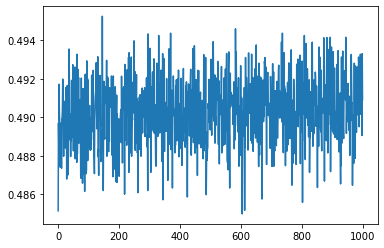

In [70]:
plt.plot(rtrbm.errors)

<AxesSubplot:>

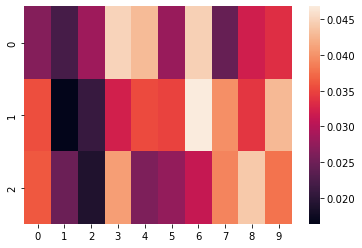

In [68]:
sns.heatmap(rtrbm.W)

<AxesSubplot:>

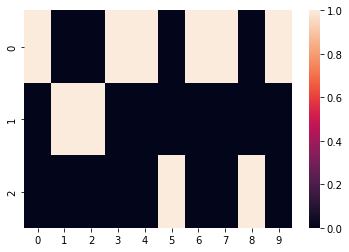

In [60]:
sns.heatmap(pre_defined_sparse_rtrbm.W)

In [45]:
import sys
sys.path.append(r"D:\OneDrive\RU\Intern\rtrbm_master\utils")


In [48]:
from plots import plot_compare_weights

ModuleNotFoundError: No module named 'plots'

In [7]:
list = []

for x in [1, 2]:
    for sp in [3e-5, 1e-2, 3e-2, 7e-2, 1e-1]:
        rtrbm = RTRBM(data, N_H=N_H, device='cpu')
        rtrbm.b_V = -.5 * torch.ones(1, N_V)
        rtrbm.W = torch.zeros(N_H, N_V)
        rtrbm.b_H = pre_defined_sparse_rtrbm.b_H
        rtrbm.b_init = pre_defined_sparse_rtrbm.b_init
        rtrbm.learn(n_epochs=1000, lr=1e-4, batchsize=100, CDk=10, mom=.9, wc=.05)

        list += [rtrbm]

  3%|▎         | 33/1000 [02:16<1:06:34,  4.13s/it]


KeyboardInterrupt: 

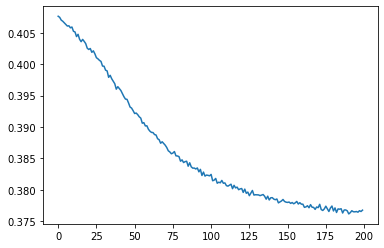

In [22]:
plt.plot(rtrbm.errors)

<AxesSubplot:>

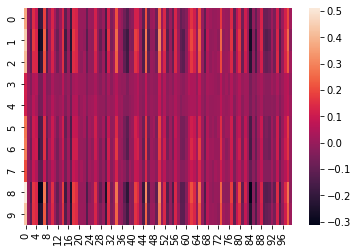

In [24]:
sns.heatmap(rtrbm.W.cpu())

In [25]:
rtrbm.learn(n_epochs=200, lr=1e-4, batchsize=100, CDk=10, mom=0, wc=0)

100%|██████████| 200/200 [41:18<00:00, 12.39s/it]


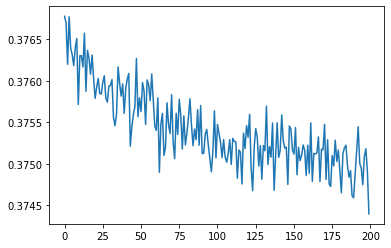

In [26]:
plt.plot(rtrbm.errors)

<AxesSubplot:>

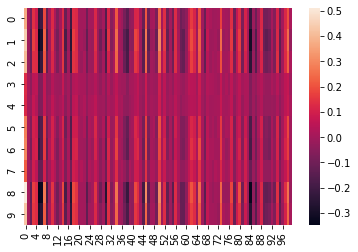

In [27]:
sns.heatmap(rtrbm.W.cpu())